# Adaptation of the reservoir. ESN example with synthetic data. Classification task

In [1]:
from numpy import *
from matplotlib.pyplot import *
import scipy.linalg

In [2]:
# text color for the plots below. Change COLOR to 'black' if you have white theme
from matplotlib import rcParams
COLOR = 'white'
rcParams['text.color'] = COLOR
rcParams['axes.labelcolor'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR

# bacground color
rcParams['figure.facecolor'] = '#080808'
rcParams['axes.facecolor'] = '#202020'

### 1. Generate synthetic data

In [3]:
data_dim = 2 # dimentionality of the data
num_samples = 500 # number of samples per class
num_classes = 3 # don't forget to change num_classes according to the number of classes in the dataset

In [4]:
# don't forget to change num_classes according to the number of classes in the dataset
np.random.seed(7)
x1 = 0.75 * np.random.standard_normal((data_dim, num_samples))
x2 = 0.5 * (np.random.standard_normal((data_dim, num_samples)) - 4)
x3 = 0.5 * (np.random.standard_normal((data_dim, num_samples)) + 4)
# x4 = 0.5 * (np.random.standard_normal((data_dim, num_samples)) + 1)
# x5 = 0.3 * (np.random.standard_normal((data_dim, num_samples)) + 8)
data = np.concatenate((x1, x2, x3), axis=1)
data.shape

(2, 1500)

In [5]:
# prepare labels
Y_train = np.zeros(shape=(num_classes, num_classes * num_samples))
for i in range(num_classes):
    Y_train[i, i * num_samples:(i + 1) * num_samples] = 1
Y_train = np.transpose(Y_train)

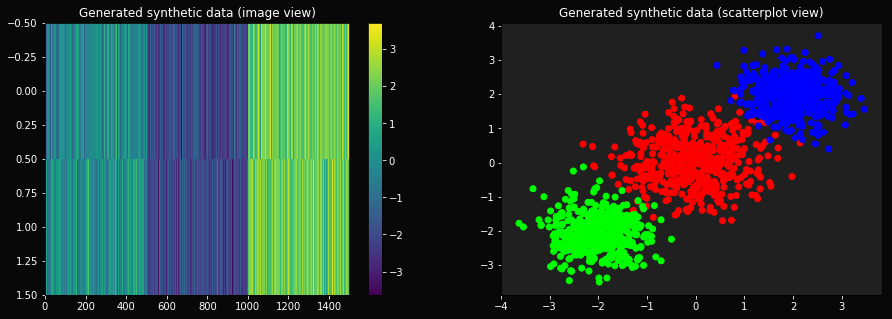

In [6]:
figure(figsize=(15,5))
subplot(1, 2, 1)
imshow(data, aspect='auto')
title("Generated synthetic data (image view)")
colorbar()

## only for 2D datasets
subplot(1, 2, 2)
title("Generated synthetic data (scatterplot view)")
scatter(data[0], data[1], c=Y_train)

#### Shuffle (optional)

Note: choose a particular shuffling strategy

* Random

In [7]:
# from sklearn.utils import shuffle
# data, Y_train = shuffle(data.T, Y_train)
# data = data.T

* Classes one by one

In [8]:
# temp_data = []
# temp_labels = []
# for i in range(0, num_samples):
#     temp_data.append(data[:,i])
#     temp_labels.append(Y_train[i])
#     temp_data.append(data[:,i + num_samples])
#     temp_labels.append(Y_train[i + num_samples])
#     temp_data.append(data[:,i + 2 * num_samples])
#     temp_labels.append(Y_train[i + 2 * num_samples])
# temp_data = array(temp_data).T
# data = temp_data
# Y_train = array(temp_labels)

### 2. Prep reservoir

The ESN implementation is based on the guidelines from [A Practical Guide to Applying Echo State Networks](https://mantas.info/get-publication/?f=Practical_ESN.pdf) by [Dr. Mantas Lukoševičius](https://mantas.info/).

In [9]:
# generate the ESN reservoir
in_size = out_size = 1
res_size = 100
a = 0.3 # leaking rate
random.seed(42)
W_in = (random.rand(res_size, 1 + in_size) - 0.5) * 1
W = random.rand(res_size, res_size) - 0.5
# normalizing and setting spectral radius (correct, slow):
print('Computing spectral radius...'),
rho_W = max(abs(linalg.eig(W)[0]))
print('Done!')
W *= 1.25 / rho_W

Computing spectral radius...
Done!


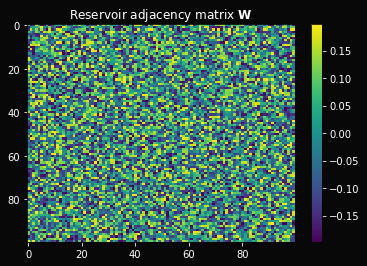

In [10]:
imshow(W, aspect='auto')
title("Reservoir adjacency matrix $\mathbf{W}$")
colorbar()

### 3. Record reservoir activations $\mathbf{x}(n)$

ESN uses an RNN type with leaky-integrated disctrete-time continuous-value units. The typical update equation is:

$\mathbf{x}(n) = (1 - \alpha)\mathbf{x}(n - 1) + \alpha \tanh (\mathbf{W}^{in}[1; \mathbf{u}(n)] + \mathbf{Wx}(n - 1))$

In [11]:
def record_reservoir_activations(data, W_in, in_size, W, init_samples = 0):
    """
    Generate and record reservoir responses to the data samples.
    
    By default, we will run the ESN in classification mode so we don't need initializaiton.
    Hence, init_samples == 0 by default. If you need to run in generative mode, change the 
    initialization accordingly.
    """
    data_dim, train_len = data.shape
    res_size = W.shape[0]
    
    # allocated memory for the design (collected states) matrix
    res_state = zeros((1 + in_size + res_size, train_len - init_samples))
    
    # run the reservoir with the data and collect X
    x = zeros((res_size, 1))
    for t in range(train_len):
        u = [sample[t] for sample in data] # get a data sample (a column from the data array)
        x = (1 - a) * x + a * tanh(dot(W_in, vstack((np.ones(data_dim), u))) + dot(W, x))
        if t >= init_samples:
            res_state[:, t - init_samples] = vstack((np.ones(data_dim), u, x))[:, 0]
    return res_state

In [12]:
X = record_reservoir_activations(data, W_in, in_size, W)

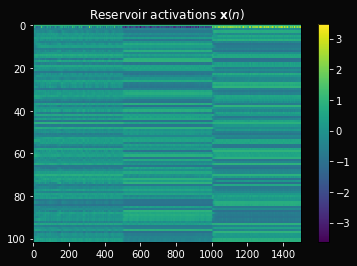

In [13]:
imshow(X, aspect='auto')
title("Reservoir activations $\mathbf{x}(n)$")
colorbar()

### 4. Peak detection. Reservoir states exploration

In [14]:
# # Peak detection
# # Time t is a ppeak if (y(t) - y(t-dt) > m) && (y(t) - y(t+dt) > m)

# figure(figsize=(25,5))
# title("Activations for different classes")
# for i in [(10, 'ro'), (510, 'go'), (1010, 'bo')]:
#     input = X.T[i[0]]
#     m = 1
#     signal = (input > np.roll(input, m)) & (input > np.roll(input, -m))
#     plot(signal.nonzero()[0], input[signal], i[1])

In [15]:
# # Peak detection
# # STD measure (Wiki-like)

# figure(figsize=(25,5))
# for i in [10, 510, 1010]:
#     input = X.T[i]
#     std = np.std(input)
#     filtered = [v if v > 1.2 * std else 0 for v in input]
#     plot(filtered)

Playing with transforms

In [16]:
from scipy import fftpack

In [17]:
def fn(signal):
    return signal # if you want to skip the transform
#     return fftpack.rfft(signal) # if you want to apply the transform

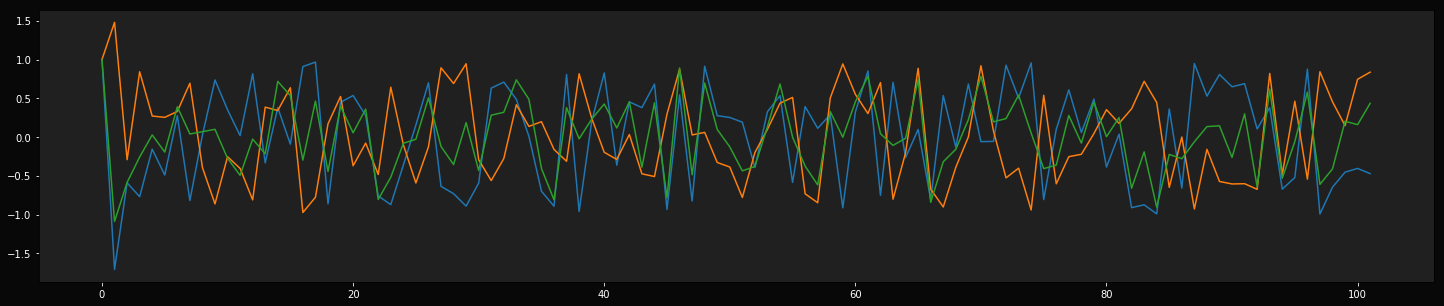

In [18]:
figure(figsize = (25,5))
plot(fn(X.T[515]))
plot(fn(X.T[1015]))
plot(fn(X.T[15]))

In [19]:
def std_peaks(signal, threshold):
    std = np.std(signal)
    filtered = [v if v > threshold * std else 0 for v in signal]
    return filtered

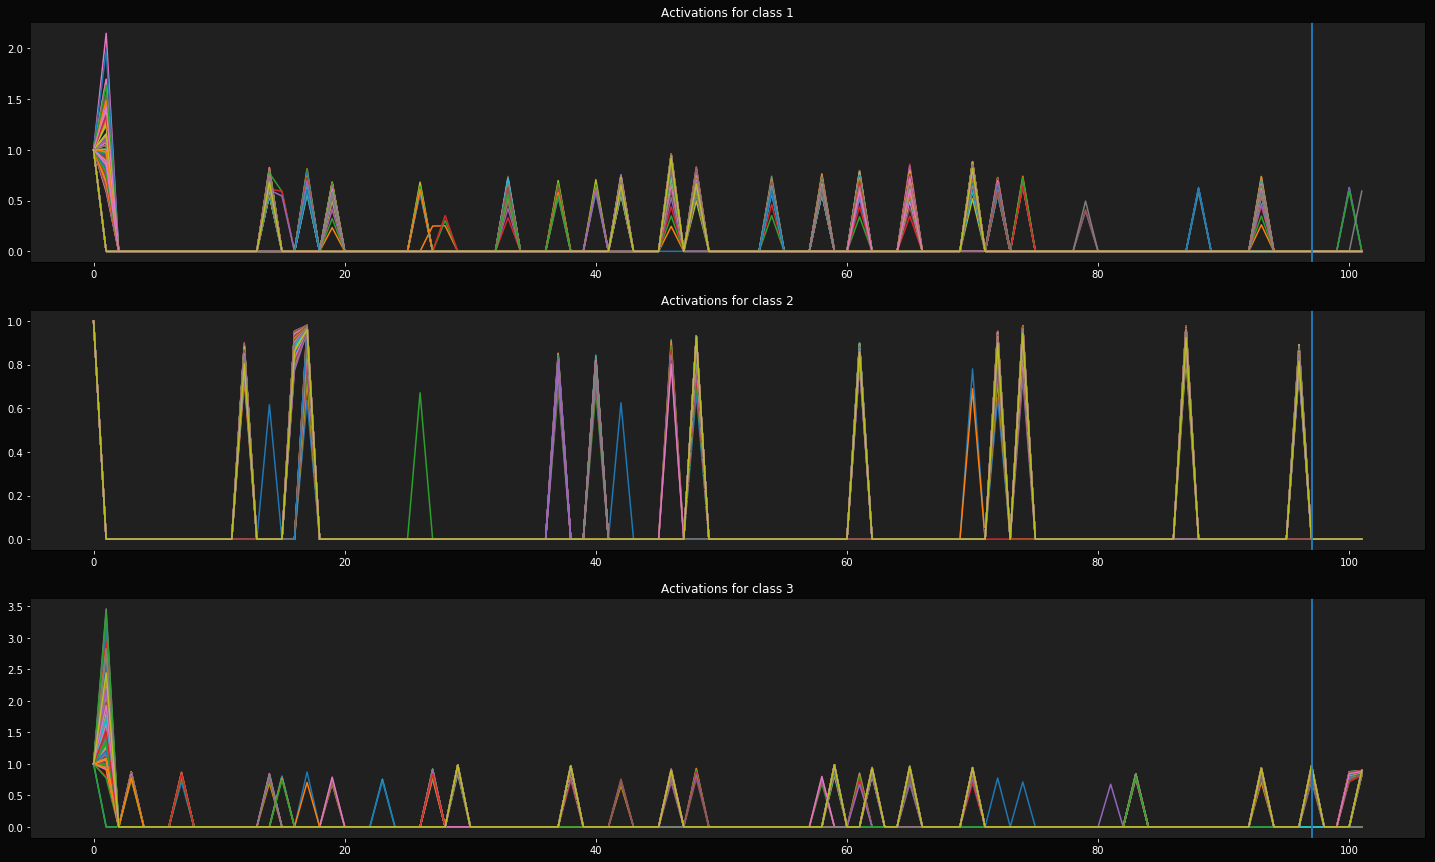

In [20]:
# Peak detection

threshold = 1.3
init = 0
position = 97 #vertival line position

figure(figsize=(25,15))
subplot(3,1,1)
title("Activations for class 1")
for i in range(0,499):
    input = fn(X.T[i, init:])
    filtered = std_peaks(input, threshold)
    plot(filtered)
    axvline(position)

subplot(3,1,2)
title("Activations for class 2")
for i in range(500,999):
    input = fn(X.T[i, init:])
    filtered = std_peaks(input, threshold)
    plot(filtered)
    axvline(position)
    
subplot(3,1,3)
title("Activations for class 3")
for i in range(1000,1499):
    input = fn(X.T[i, init:])
    filtered = std_peaks(input, threshold)
    plot(filtered)
    axvline(position)

In [21]:
X_peaks = np.apply_along_axis(fn, 0, X)
X_peaks = np.apply_along_axis(std_peaks, 0, X_peaks, threshold)

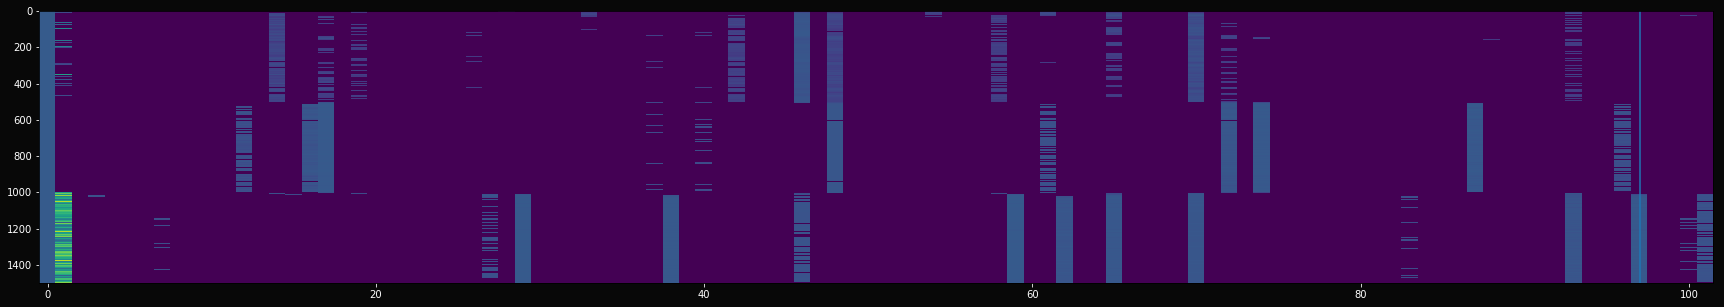

In [22]:
figure(figsize=(30,5))
axvline(97)
imshow(X_peaks.T, aspect='auto')

### 5. Reservoir adaptation

In [23]:
import networkx as nx

In [24]:
G_random = nx.from_numpy_matrix(W)
# nx.write_gexf(G_random, 'graph_random.gexf')

In [25]:
edge_weights = {}
for edge in G_random.edges:
#     edge_weights[edge] = 0
    w = 0
    for tpl in zip(X_peaks[edge[0]], X_peaks[edge[1]]):
        if tpl[0] > 0 and tpl[1] > 0:
            w += 1.0
        else:
            w += 0.0
    edge_weights[edge] = w

In [26]:
nx.set_edge_attributes(G_random, name = 'weight', values = edge_weights)

In [39]:
W_adapted = np.array(nx.adjacency_matrix(G_random).todense())

In [56]:
# normalizing and setting spectral radius (correct, slow):
print('Computing spectral radius...'),
rho_W_adapted = max(abs(linalg.eig(W_adapted)[0]))
print('Done!')
W_adapted *= 1.25 / rho_W_adapted

Computing spectral radius...
Done!


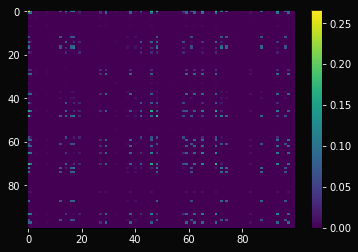

In [57]:
imshow(W_adapted, aspect='auto')
colorbar()

In [58]:
X_adapted = record_reservoir_activations(data, W_in, in_size, W_adapted)

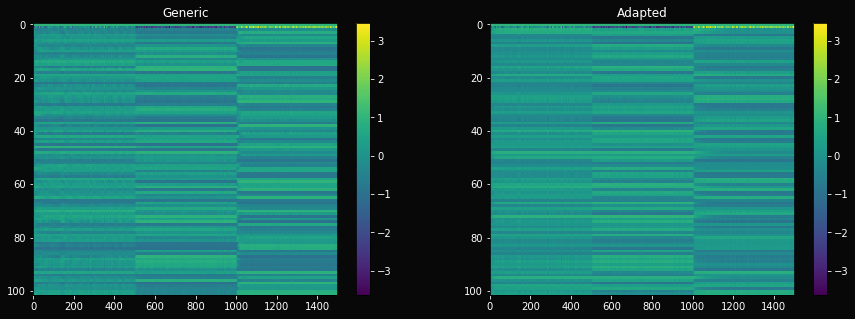

In [59]:
figure(figsize=(15,5))
subplot(1,2,1)
imshow(X, aspect='auto')
title('Generic')
colorbar()

subplot(1,2,2)
imshow(X_adapted, aspect='auto')
title('Adapted')
colorbar()

### 4. Train the readout $\mathbf{W}^{out}$

In [60]:
# train the output by ridge regression
reg = 1e-8  # regularization coefficient
X_T = X_adapted.T
W_out = dot(dot(Y_train.T, X_T), linalg.inv(dot(X_adapted, X_T) + reg * eye(1 + in_size + res_size)))

Text(0.5,1,'Output weights $\\mathbf{W}^{out}$')

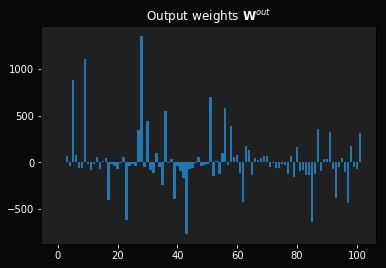

In [61]:
bar(range(1 + in_size + res_size), [v[0] for v in W_out.T])
title('Output weights $\mathbf{W}^{out}$')

### 5. Test

#### Generate test dataset

In [62]:
x1 = 0.75 * np.random.standard_normal((data_dim, num_samples))
x2 = 0.5 * (np.random.standard_normal((data_dim, num_samples)) - 4)
x3 = 0.5 * (np.random.standard_normal((data_dim, num_samples)) + 4)
# x4 = 0.5 * (np.random.standard_normal((data_dim, num_samples)) + 1)
# x5 = 0.3 * (np.random.standard_normal((data_dim, num_samples)) + 8)
data_test = np.concatenate((x1, x2, x3), axis=1)
data_test.shape

(2, 1500)

In [63]:
# prepare labels
Y_test = np.zeros(shape=(num_classes, num_classes * num_samples))
for i in range(num_classes):
    Y_test[i, i * num_samples:(i + 1) * num_samples] = 1
Y_test = np.transpose(Y_test)

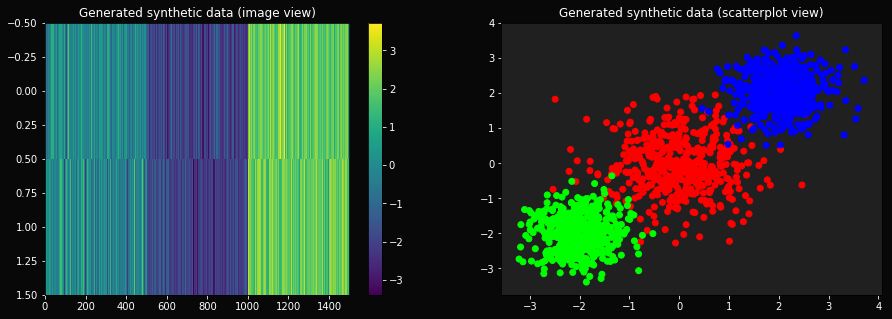

In [64]:
figure(figsize=(15,5))
subplot(1, 2, 1)
imshow(data_test, aspect='auto')
title("Generated synthetic data (image view)")
colorbar()

## only for 2D datasets
subplot(1, 2, 2)
title("Generated synthetic data (scatterplot view)")
scatter(data_test[0], data_test[1], c=Y_test)

#### Record reservoir activations for the test set

In [65]:
X_test = record_reservoir_activations(data_test, W_in, in_size, W_adapted)

#### Get results of testing. Compute MSE

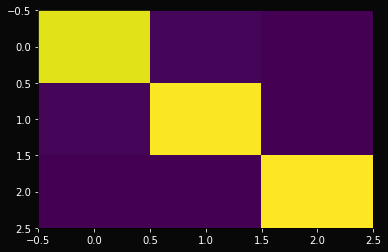

In [66]:
Y_target = dot(W_out, X_test)
imshow(dot(Y_target, Y_target.T), aspect='auto')

In [67]:
# compute MSE for the first errorLen time steps
error_len = num_classes * num_samples
mse = sum(square(Y_train.T - Y_target )) / error_len
print('MSE = ' + str(mse))

MSE = 0.009519513471870682
